Accuracy: 0.7972972972972973

Top features by mean |SHAP|:
      feature  mean_abs   std_abs  rank  relative_share
0  sex_female  0.125242  0.051153     1        0.253457
1    sex_male  0.095579  0.038897     2        0.193427
2         age  0.078452  0.072773     3        0.158767
3        fare  0.071564  0.054425     4        0.144827
4    pclass_3  0.066674  0.046852     5        0.134931
5    pclass_1  0.042416  0.035926     6        0.085839
6    pclass_2  0.014206  0.014072     7        0.028750

Sensitive feature checks:
  sensitive            related_cols  relative_share  min_rank  flagged
0       sex  [sex_female, sex_male]        0.446885         1     True
1       age                   [age]        0.158767         3     True

Perturbation results (mean absolute change in predicted prob):
  sensitive  mean_abs_delta
0       sex        0.334054
1       age        0.191353


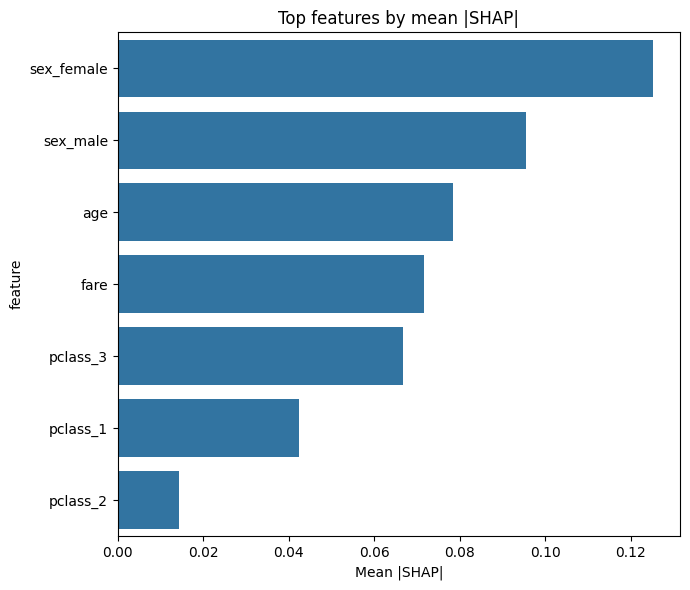

In [5]:
!pip install pandas numpy matplotlib seaborn scipy
!pip install scikit-learn shap lime

import shap, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Simple config
SENSITIVE_initial = ['sex', 'age', 'embarked'] # Keep original for reference
EPS = 0.05
TOPK = 5
SHAP_SAMPLE = 300


# 1) Load and keep a few columns
ds = pd.read_csv("/content/titanic.csv")

# Normalize all column names to lowercase to avoid case-sensitivity issues
ds.columns = ds.columns.str.lower()

# Define desired columns and filter to only include those actually present
desired_cols = ['pclass','sex','age','sibsp','parch','fare','embarked','survived']
available_cols = [col for col in desired_cols if col in ds.columns]

# Check if 'survived' is available, it's essential
if 'survived' not in available_cols:
    raise ValueError("The 'survived' column is not found in the dataset. Cannot proceed.")

# Select relevant columns and drop rows with NaN values
df = ds[available_cols].dropna().reset_index(drop=True)

# Separate features (X_raw) and target (y)
X_raw = df.drop(columns=['survived'])
y = df['survived'].astype(int)

# Update SENSITIVE list based on actually available features
SENSITIVE = [s for s in SENSITIVE_initial if s in X_raw.columns]

# 2) Prepare features (one-hot for categorical)
X = df.drop(columns=['survived'])
cat_cols_initial = ['sex','embarked','pclass']
# Filter categorical columns to only include those present in X
cat_cols = [col for col in cat_cols_initial if col in X.columns]
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)
feature_names = X_enc.columns.tolist()


# 3) Split & train
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig = train_test_split(
    X_enc, y, X, test_size=0.25, random_state=42, stratify=y
)
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))


# 4) SHAP explanations (robust handling)
sample = X_test.sample(n=min(SHAP_SAMPLE, len(X_test)), random_state=42)
explainer = shap.TreeExplainer(model)
shap_out = explainer.shap_values(sample)


# Normalize shap_out -> 2D array shap_vals (n_samples x n_features)
if isinstance(shap_out, list):
    shap_vals = shap_out[1] if len(shap_out) > 1 else shap_out[0]
elif isinstance(shap_out, np.ndarray):
    if shap_out.ndim == 3:            # (n, features, n_classes)
        idx = 1 if shap_out.shape[2] > 1 else 0
        shap_vals = shap_out[:, :, idx]
    elif shap_out.ndim == 2:
        shap_vals = shap_out
    else:
        raise ValueError("Unhandled SHAP shape: " + str(shap_out.shape))
else:
    raise ValueError("Unhandled SHAP return type")

shap_abs = pd.DataFrame(np.abs(shap_vals), columns=sample.columns, index=sample.index)


# 5) Aggregate: mean, std, rank, relative share
agg = pd.DataFrame({
    'feature': shap_abs.columns,
    'mean_abs': shap_abs.mean(axis=0),
    'std_abs': shap_abs.std(axis=0)
}).sort_values('mean_abs', ascending=False).reset_index(drop=True)
agg['rank'] = np.arange(1, len(agg)+1)
agg['relative_share'] = agg['mean_abs'] / agg['mean_abs'].sum()

print("\nTop features by mean |SHAP|:")
print(agg.head(10))


# 6) Simple flagging for sensitive features
flags = []
for s in SENSITIVE:
    related = [f for f in agg['feature'] if f.startswith(s + '_') or f == s]
    if not related and s in agg['feature'].values:
        related = [s]
    if not related:
        print(f" - Sensitive feature '{s}' not found (skipping). Beware: '{s}' was defined as sensitive but is not in the processed features.")
        continue
    mean_sum = agg.set_index('feature').loc[related, 'mean_abs'].sum()
    rel = mean_sum / agg['mean_abs'].sum()
    ranks = agg.set_index('feature').loc[related, 'rank']
    min_rank = int(ranks.min())
    flagged = (rel > EPS) or (min_rank <= TOPK)
    flags.append({'sensitive': s, 'related_cols': related, 'relative_share': rel, 'min_rank': min_rank, 'flagged': flagged})

print("\nSensitive feature checks:")
print(pd.DataFrame(flags))


# Minimal-fix perturbation function (handles pandas CategoricalDtype)
def perturb_rows(orig_df, feature):
    dfp = orig_df.copy()
    if feature not in dfp.columns:
        return dfp
    # Use pandas dtype check (safe for categorical dtypes)
    if pd.api.types.is_numeric_dtype(dfp[feature].dtype):
        dfp[feature] = dfp[feature].median()
    else:
        vals = dfp[feature].dropna().unique().tolist()
        if len(vals) > 1:
            mode = dfp[feature].mode().iloc[0]
            alt = next((v for v in vals if v != mode), vals[0])
            dfp[feature] = alt
    return dfp


# 7) Simple perturbation: numeric->median, categorical->swap to other value
perturb_orig = X_test_orig.sample(n=min(200, len(X_test_orig)), random_state=42)
perturb_enc = X_test.loc[perturb_orig.index]
if hasattr(model, "predict_proba"):
    orig_probs = model.predict_proba(perturb_enc)[:, 1]
else:
    orig_probs = model.predict(perturb_enc)

perturb_stats = []
for s in SENSITIVE:
    if s not in X.columns:
        print(f"Skipping perturbation for '{s}' (not in original X columns after feature selection).")
        continue
    pert = perturb_rows(perturb_orig, s)
    pert_enc = pd.get_dummies(pert, columns=cat_cols, drop_first=False).reindex(columns=feature_names, fill_value=0)
    if hasattr(model, "predict_proba"):
        pert_probs = model.predict_proba(pert_enc)[:, 1]
    else:
        pert_probs = model.predict(pert_enc)
    delta = np.abs(orig_probs - pert_probs)
    perturb_stats.append({'sensitive': s, 'mean_abs_delta': float(delta.mean())})

print("\nPerturbation results (mean absolute change in predicted prob):")
print(pd.DataFrame(perturb_stats))


# 8) Plot top features
plt.figure(figsize=(7,6))
topn = min(15, len(agg))
sns.barplot(x='mean_abs', y='feature', data=agg.head(topn))
plt.title('Top features by mean |SHAP|')
plt.xlabel('Mean |SHAP|')
plt.tight_layout()
plt.show()